## Example of Trans-C sampling across independent model states

This notebook demonstrates sampling across unormalized multi-dimensional Gaussian PDFs in states with non-consequtive dimensions
using the Ensemble resampler.

In [1]:
# general python utility packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
from tqdm import tqdm
import corner
import time
from collections import Counter
from matplotlib.ticker import MaxNLocator
import pickle as pickle
from scipy.optimize import minimize

#### TransC class

In [2]:
from pyTransC import TransC_Sampler

In [3]:
def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return np.array(flat_list)

--------

## Example set up: Three states with non-consecutive dimensions, 3D, 5D and 10D Gaussians

Set some global control parameters for all examples.

In [4]:
plotting = True      # Create some diagnostic displays of outputs
parallel = False     # Use parallel computation for sampling
autopseudo = True    # Use automatic generation of pseudo-prior function, as alternate to user specified Gaussian.
autothin = False     # Thin internally generated within state posterior ensembles by their auto-correlation 
                     # (This can take additional compute time, and is not necessary if input ensembles are already independent.)

Define log posterior PDF for three states with Gaussian posterior PDF.

First we set up three unormalized Gaussian states.

In [5]:
# Set up PDFs in each state
nstates = 3                                      # Number of states
ndims = [3,5,10]                                 # Number of dimensions for each state
weights = [0.56,0.3,0.14]                        # weights for each state (become true values for relative evidence/marginal Likelihoods.
trueML = weights/np.sum(weights)                 # true values of marginal Likelihoods/relative evidences
mu = [[0.8,0.8,0.8],[0.3 for i in range(5)],[0.5 for i in range(10)]] # Gaussian means for each state
sig = [0.02,0.05,0.08]                           # standard deviations of Gaussians in each state
cov = [np.diag(np.ones(ndims[i])*sig[i]**2) for i in range(nstates)] # covariance matrices for each state
if(True):                                        # rotate the covariance matrices
    np.random.seed(210165)
    new_cov = []
    for i in range(nstates):
        rotation_matrix = np.random.rand(ndims[i],ndims[i])-0.5
        new_cov.append(rotation_matrix @ cov[i] @ rotation_matrix.T)
    cov = new_cov
icov = [np.linalg.inv(cov[0]),np.linalg.inv(cov[1]),np.linalg.inv(cov[2])] # inverse covariance matrices for each state

### Log-posterior PDF
Define log_posterior function using these Gaussian PDFs.

In [6]:
def log_posterior(x,state,ndims,mu,cov,weights,icov=False): # Multi-state log Posterior PDF evaluation (unormalised) for three multi-dimensional Gaussians
    w = weights[state]
    mean = mu[state]
    covar = cov[state]
    r = mean-x 
    if(icov):
        if(ndims[state] == 1): 
            log_const = np.log(w) - 0.5*len(x)*np.log(2*np.pi) - 0.5*np.log(covar[0])
            out = log_const-0.5 * np.dot(r,r)*(covar[0])
        else:
            log_const = np.log(w) - 0.5*len(x)*np.log(2*np.pi) - 0.5*np.log(np.linalg.det(covar)) 
            out = log_const-0.5 * np.dot(r, np.dot(covar, r))
    else:
        if(ndims[state] == 1): 
            log_const = np.log(w) - 0.5*len(x)*np.log(2*np.pi) - 0.5*np.log(covar[0])
            out = log_const-0.5 * np.dot(r,r)/(covar[0])
        else:
            log_const = np.log(w) - 0.5*len(x)*np.log(2*np.pi) - 0.5*np.log(np.linalg.det(covar)) 
            out = log_const-0.5 * np.dot(r, np.linalg.solve(covar, r))
    return out
    
log_posterior_args = [ndims,mu,cov,weights]

### Starting points for MCMC samplers

In [7]:
# first we optimize each state to find good starting point for all McMC samplers
np.random.seed(42)
if(True):
    nll = lambda *args: -log_posterior(*args)
    initial = np.array([0.5])
    ml = []
    print("Maximum likelihood estimates:")
    for i in range(nstates):
        soln = minimize(nll, initial, args=(i,ndims,mu,cov,weights))
        ml.append(soln.x)
        print("x_ml = {0:.3f}".format(soln.x[0]))

Maximum likelihood estimates:
x_ml = 0.800
x_ml = 0.300
x_ml = 0.500


### Decide on normalized pseudo prior PDFs

Here we demonstrate how to define a pseudo_prior PDF, by either

    - fitting a mixture model approximation to existing ensembles (autopseudo=True),

    - defining a Gaussian within each state (autopseudo=False)

Our implementation of an automatic pseudo prior function, uses the supplied class function `build_pseudo_prior`.  This class function is essentially a wrapper routine around calls to `run_mcmc_per_state` and `run_fitmixture`, similar to the pre calculation below for `run-ens-sampler`. To encourage independence of samples produced `run_mcmc_per_state`, the ensembles input to `run_fitmixture` are thinned using the Markov chain correlation times calculated for each state.

Use of `autothin=True` means that auto correlation times are calculated for each space and the ensembles used to construct pseudo_priors are thinned by this value. This slows down the procedure because the auto correlation calculation is relatively slow.

In truth the question of how to build a normalized PDF approximation of the posterior (for use as a pseudo-prior) is an open question, and so `build_pseudo_prior` should be taken as a simple example implementation of this.

In [8]:
if(autopseudo): # Automatic pseudo prior function
    nwalkers_auto = 32                                                # Number of walkers for auto pseudo prior fitting
    nsteps_auto = 1000                                               # Number of chain steps for auto pseudo prior fitting
    pos_states = np.random.choice(np.arange(nstates),nwalkers_auto) # Initial states of each walker for auto pseudo prior fitting
    pos = []
    for i in range(nstates): # generate starting points for each chain in each state
        pos.append(ml[i] + 1e-4 * np.random.randn(nwalkers_auto, ndims[i])) # add random perturbation to maximum Likelihood models
    
    tcs = TransC_Sampler(nstates,ndims) # create instances of states
    auto_log_pseudo_prior = tcs.build_auto_pseudo_prior(pos,log_posterior,log_posterior_args=log_posterior_args,
                                                   nwalkers=nwalkers_auto,nsamples=nsteps_auto,autothin=autothin,parallel=parallel)

    log_pseudo_prior_args = []   # additional argument list beyond (x,state) for log_pseudo_prior function

    def log_pseudo_prior(x,state,returndeviate=False):               # multi-state log pseudo-prior density and deviate generator
        return auto_log_pseudo_prior(x,state,returndeviate=returndeviate)

else:  # A Gaussian pseudo prior within each model state

    def log_pseudo_prior(x,state,ndims,returndeviate=False):               # multi-state log pseudo-prior density and deviate generator
        mu = [[0.6],[0.7,0.7,0.7],[0.2,0.2,0.2,0.2,0.2]]                   # Gaussian means for each state
        sig = [0.025,0.055,0.085]                                          # standard deviations of isotropic Gaussians in each state
        cov = [np.array([sig[0]**2]),np.diag(np.ones(ndims[1])*sig[1]**2),
                np.diag(sig[2]**2*np.ones(ndims[2]))]                       # covariance matrices for each state
        if(returndeviate):
            x = stats.multivariate_normal.rvs(mean=mu[state],cov=cov[state]) # spherical multi-dimensional Gaussian
            logppx = stats.multivariate_normal.logpdf(x,mean=mu[state],cov=cov[state]) # spherical multi-dimensional Gaussian
            if(type(x) != np.ndarray): x = np.array([x]) # deal with 1D case which returns a scalar
            return logppx,x
        else:
            return stats.multivariate_normal.logpdf(x,mean=mu[state],cov=cov[state]) # spherical multi-dimensional Gaussian 

    log_pseudo_prior_args = [ndims]   # additional argument list beyond (x,state)    

-----------

Now we are ready to apply the three algorithms to sampling over the model states.

## Trans-C sampling across posterior ensembles, using the ensemble resampler

Calculate marginal Likelihoods across states using ensemble sampler algorithm.

### Preliminaries 

#### Build posterior ensembles in each state

We need to either read in or build posterior ensembles in each state. Here we generate them with a standard MCMC sampler.

First we optimize each state to find a good starting point for McMC sampler

Set up input choices for MCMC sampler.

In [9]:
# setup of MCMC sampler
nsamples =[50000,50000,50000] # number of samples per chain for sampling of each state
nwalkers = [32,32,32] # number of mcmc chains to run simultaneously in each state
pos = []
for i in range(nstates): # generate starting points for each chain in each state
    pos.append(ml[i] + 1e-4 * np.random.randn(nwalkers[i], ndims[i])) # add random perturbation to maximum Likelihood models

First instantiate the class.

In [10]:
# perform initiation of sampler
tcs3 = TransC_Sampler(nstates,ndims) # create instances of states

Run Ensemble resampler in each state separately.

In [11]:
# first step: run Ensemble sampler in each state
start_time = time.time()
ensemble_per_state, log_posterior_ens = tcs3.run_mcmc_per_state( 
        nwalkers,                                  # int or list containing number of walkers for each state
        nsamples,                                  # number of chain steps per walker
        pos,                                       # starting positions for walkers in each state
        log_posterior,                             # log Likelihood x log_prior
        log_posterior_args=log_posterior_args,     # log posterior additional arguments (optional)
        discard=0,                                 # burnin number of chain steps to discard in eeach state
        autothin=True,                             # thinning value, save every `thin` models
        progress=True)                             # show progress bar for each state
elapsed_time = time.time() - start_time
print(' Elapsed time                                     :', np.round(elapsed_time,2),'s \n')
print(' Number of samples in each state                  :',*[len(tcs3.ensemble_per_state[i]) for i in range(nstates)])


Running within-state sampler separately on each state

Number of walkers               :  [32, 32, 32]

Number of states being sampled:  3
Dimensions of each state:  [3, 5, 10]


100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:23<00:00, 2085.97it/s]


 Elapsed time                                     : 68.5 s 

 Number of samples in each state                  : 76187 55169 27115


#### Build pseudo priors by fitting a Gaussian mixture to posterior ensembles in each state

Fit a mixture model in each state to create an automatic pseudo prior, and then evaluate that pseudo_prior for all points in the ensembles. This uses the posterior ensembles `TransC_Sampler.ensemble_per_state[s],s=1,...,nstates` and their log-posterior values `TransC_Sampler.log_posterior_ens[s], s=1,...,nstates`, and produces an ensemble of log-pseudo-prior values which are placed in `TransC_Sampler.log_pseudo_prior_ens[s],s=1,...,nstates`. These are then provided to the ensemble resampler `TransC_Sampler.run_ensemble_resampler`.

In [12]:
# fit a mixture model to each state to get a normalized pseudo prior PDF.
log_pseudo_prior_ens = tcs3.run_fitmixture(ensemble_per_state,log_posterior_ens,reg_covar=0.) 

Plot input samples in corner plot for reference.

 State;  0  in  3  dimensions
 State;  1  in  5  dimensions
 State;  2  in  10  dimensions


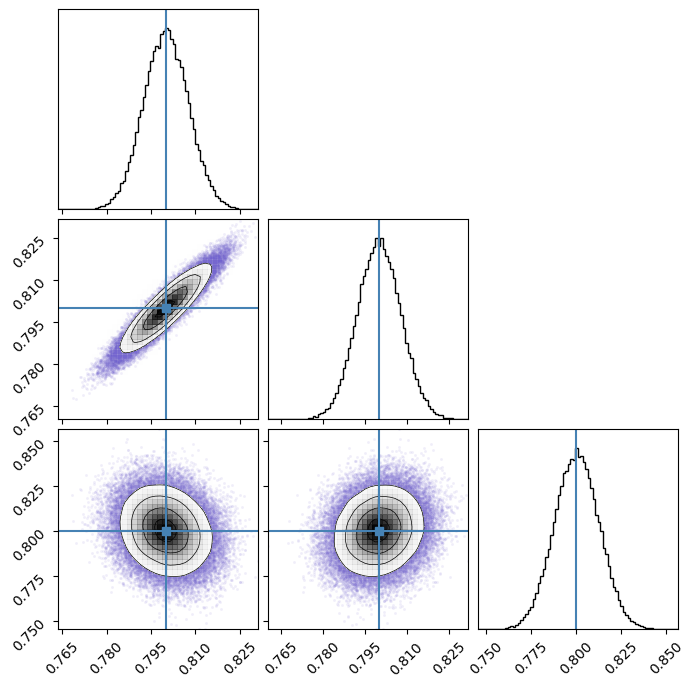

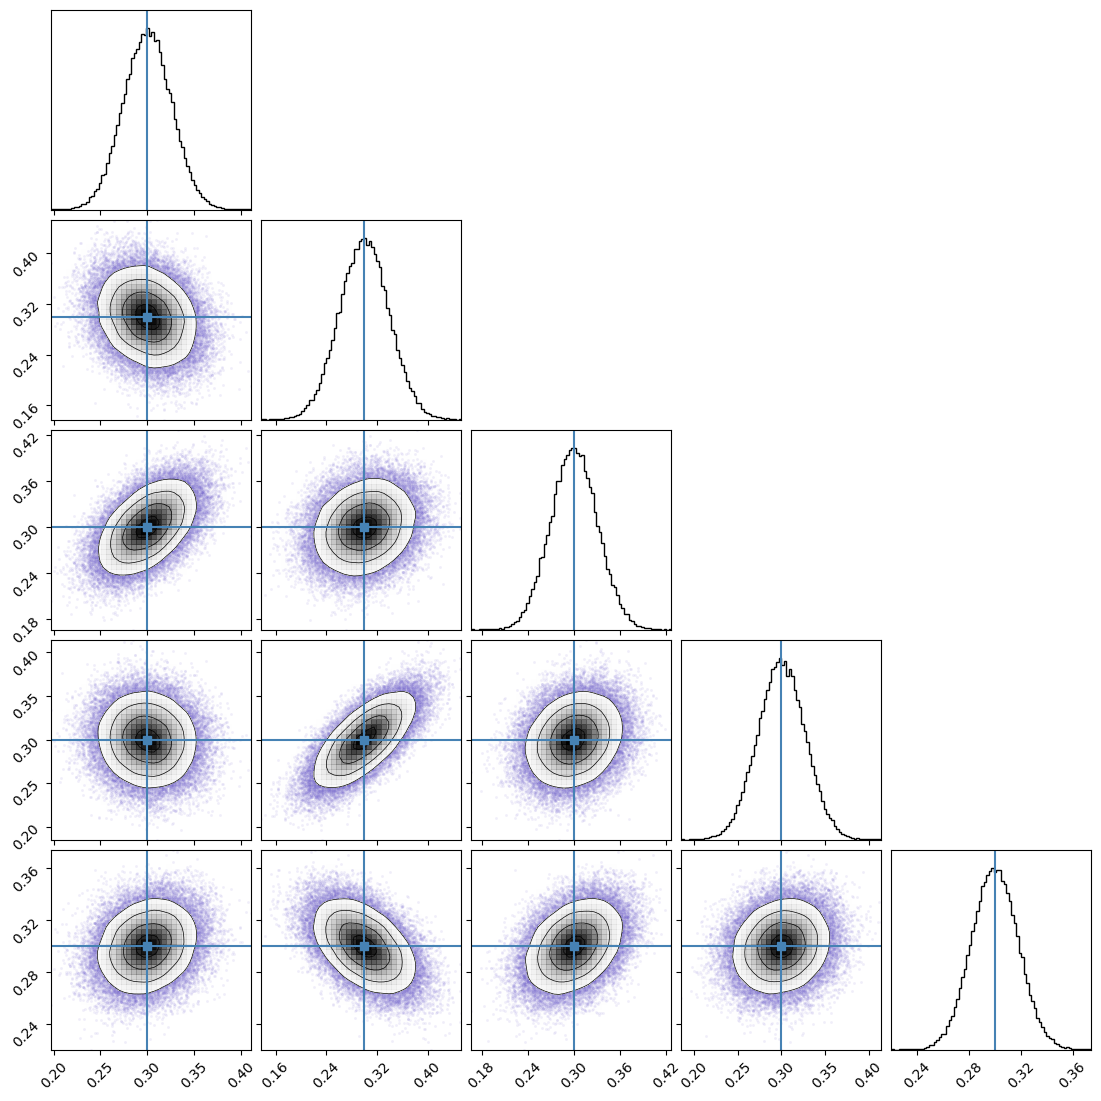

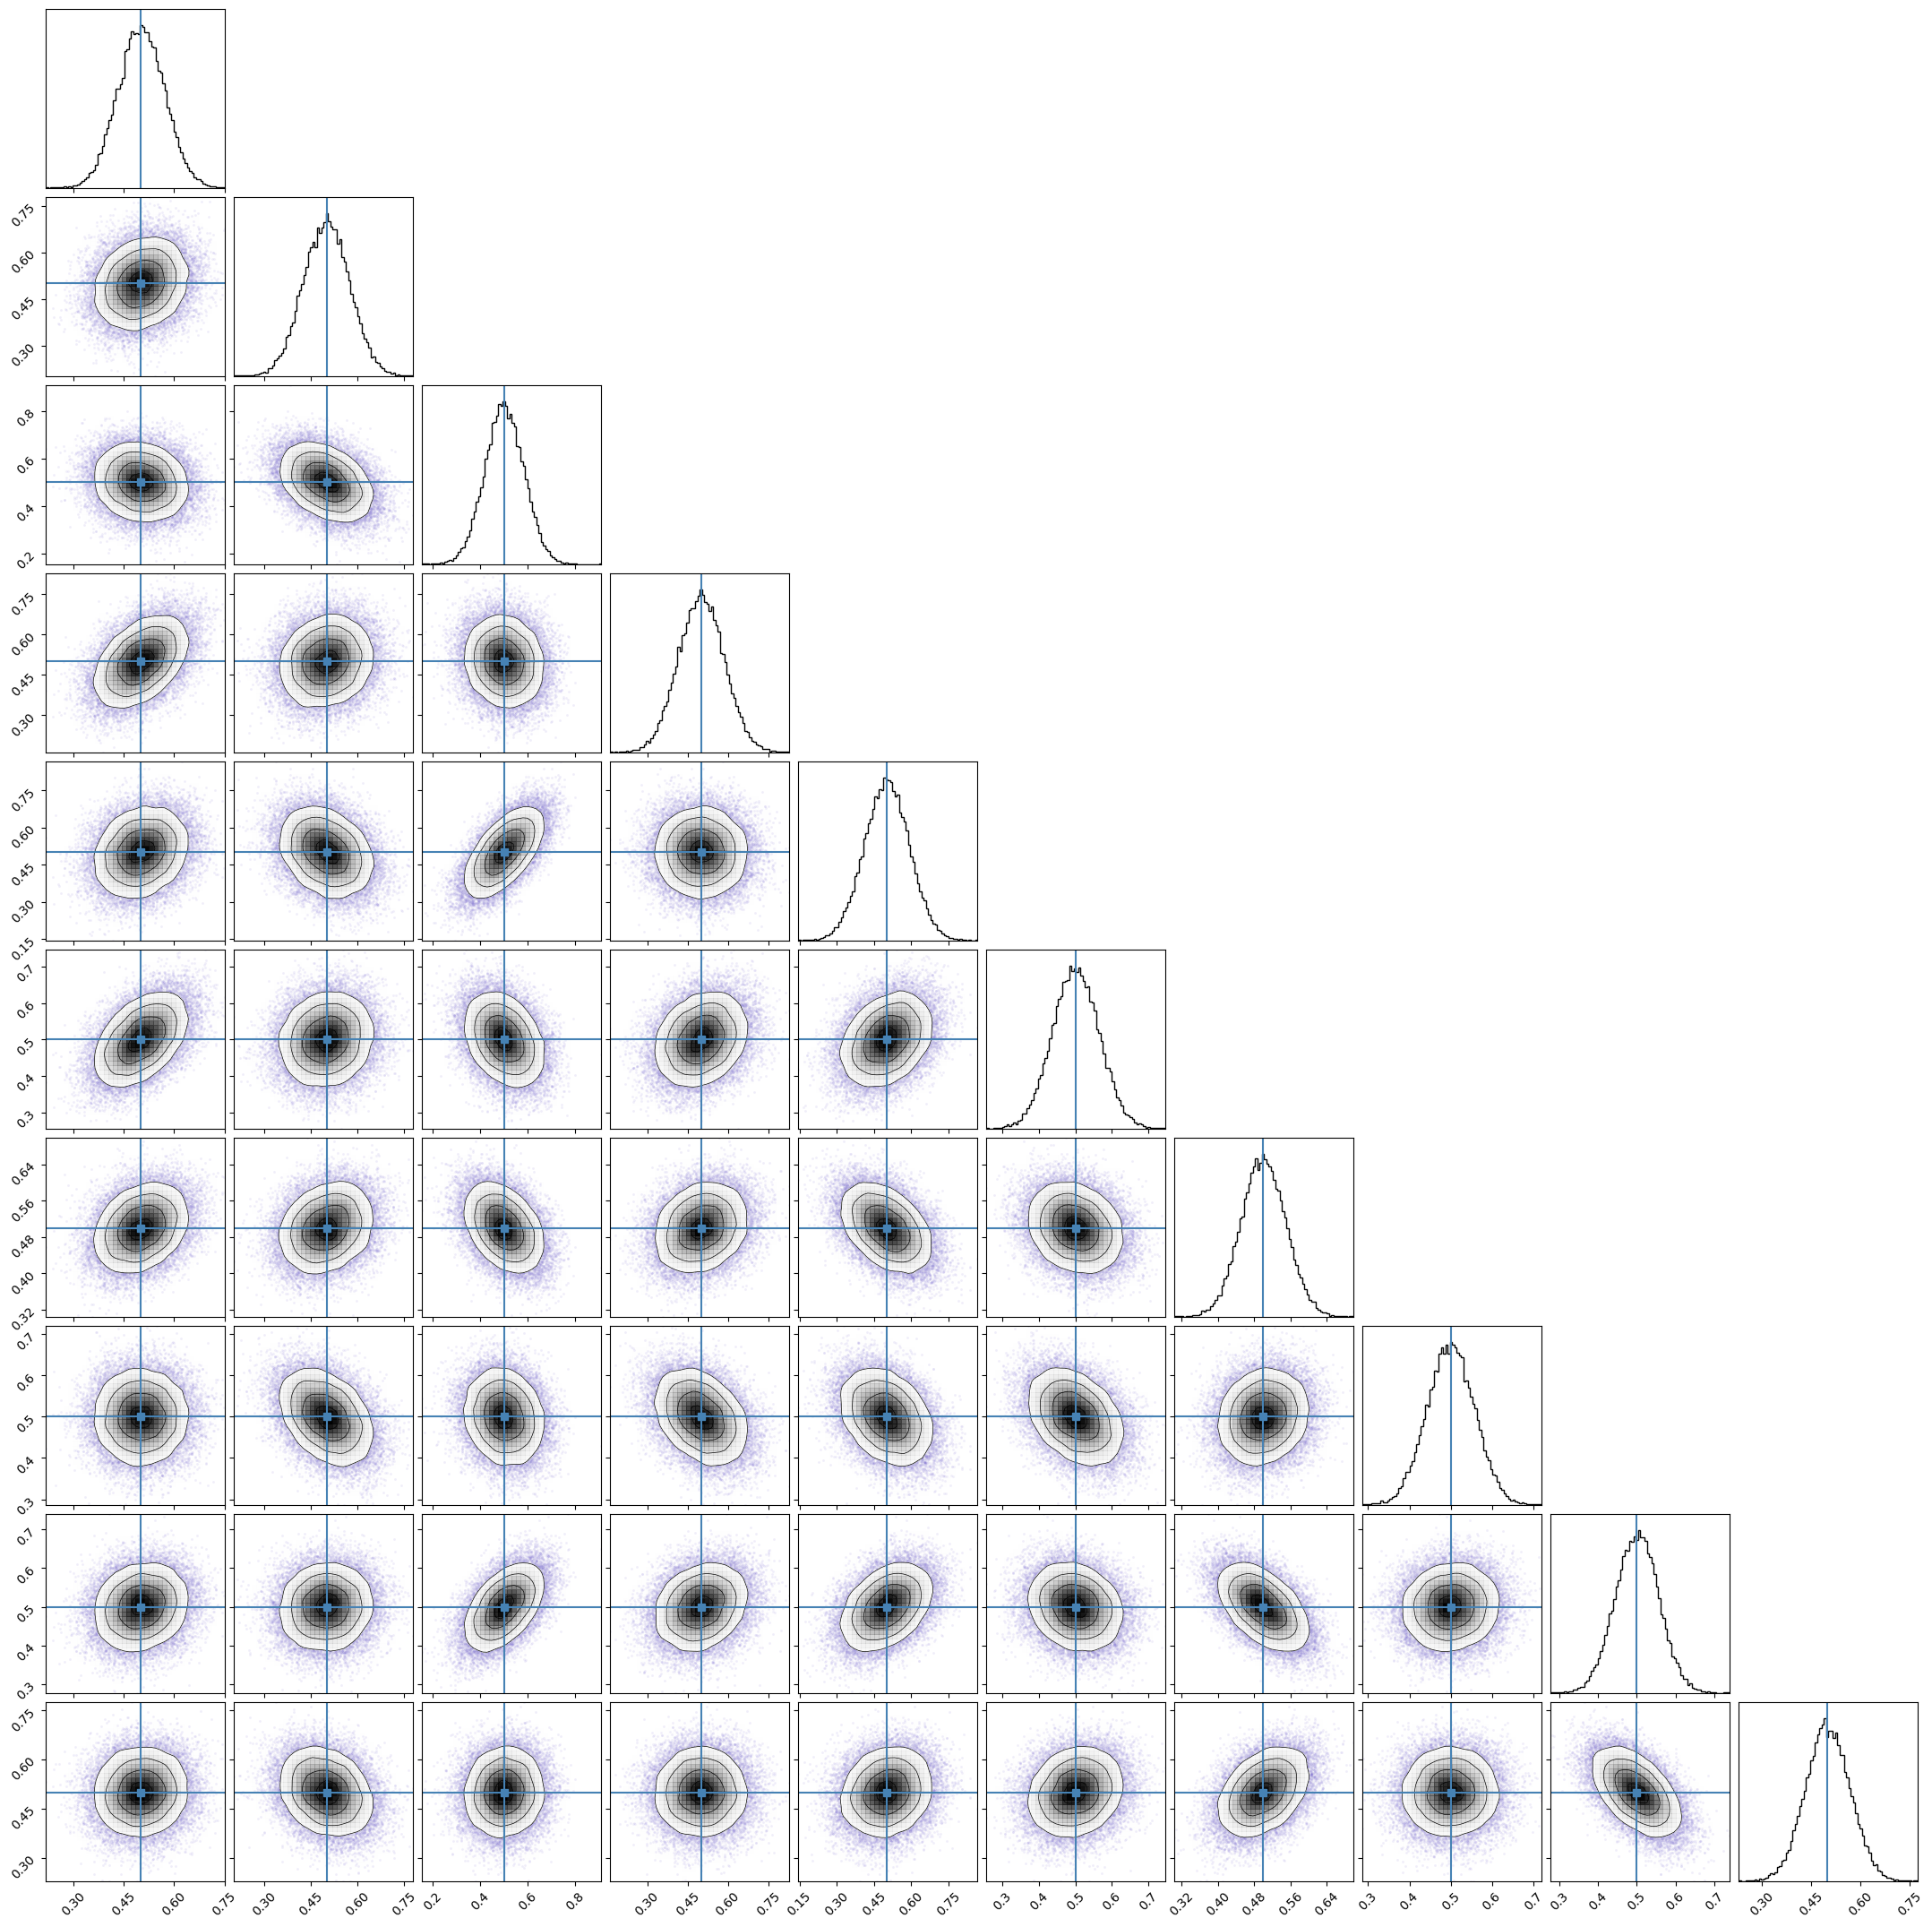

In [13]:
# corner plots to check sampling within each state
if(plotting):
    contour_kwargs = {"linewidths" : 0.5}
    data_kwargs = {"color" : "darkblue"}
    data_kwargs = {"color" : "slateblue"}
    for i in range(nstates):
        string = 'State '+str(i)
        print(' State; ',i,' in ',ndims[i],' dimensions')
        fig = corner.corner(
            ensemble_per_state[i], 
            truths=mu[i],
            title=string,
            bins=40,hist_bin_factor=2,smooth=True,contour_kwargs=contour_kwargs,data_kwargs=data_kwargs
            );

In [14]:
# Calculate marginal Likelihoods using ensembles for each state
nwalkers = 32   # number of independent random walkers across ensembles
nsteps = 100000 # number of chain steps for each walker
start_time = time.time()
result = tcs3.run_ensemble_resampler(nwalkers,
                                   nsteps,
                                   progress=True,
                                   parallel=parallel,
                                   log_posterior_ens=log_posterior_ens,
                                   log_pseudo_prior_ens=log_pseudo_prior_ens) # run mcmc sampler over ensembles to get marginal Likelihoods between states
elapsed_time = time.time() - start_time


Running ensemble trans-D resampler

Number of walkers               :  32
Number of states being sampled  :  3
Dimensions of each state        :  [3, 5, 10]


100%|████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:26<00:00,  1.21it/s]


In [15]:
# print some diagnostics
print('\n Algorithm type                                      :', tcs3.alg)
print(' Average % acceptance rate for within states         :',np.round(tcs3.accept_within,2))
print(' Average % acceptance rate for between states        :',np.round(tcs3.accept_between,2))

# extract trans-D samples and chains
discard = 0                  # chain burnin
thin = 15                    # chain thinning
chain,states_chain = tcs3.get_visits_to_states(discard=discard,thin=thin,normalize=True,
                                               walker_average='median',return_samples=True)

print(' Auto correlation time for between state sampling    :',np.round(tcs3.autocorr_time_for_between_state_jumps,3))
print(' Total number of state changes for all walkers       :',tcs3.total_state_changes)
#print(' Number of state changes for each walker             :\n',*tcs3.state_changes_perwalker)
print(' True relative marginal Likelihoods                  :', *trueML)
print(' Estimated relative evidences                        :', *np.round((tcs3.relative_marginal_likelihoods),5))
print(' Elapsed time                                        :', np.round(elapsed_time,2),'s \n')


 Algorithm type                                      : TransC-ensemble-resampler
 Average % acceptance rate for within states         : 100.0
 Average % acceptance rate for between states        : 58.04
 Auto correlation time for between state sampling    : 1.128
 Total number of state changes for all walkers       : 123106
 True relative marginal Likelihoods                  : 0.56 0.3 0.14
 Estimated relative evidences                        : 0.55936 0.30066 0.13999
 Elapsed time                                        : 26.38 s 



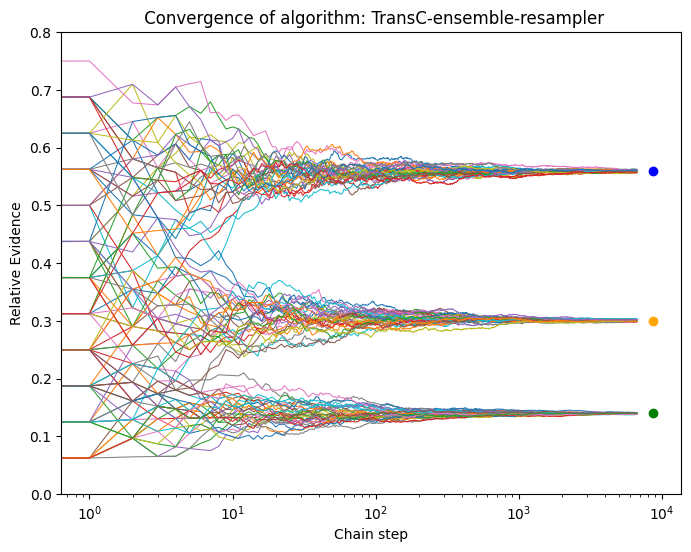

In [16]:
# plot relative number of visit to each state along the chain
if(plotting):
    key = tcs3
    fig, axes = plt.subplots(figsize=(8,6))
    if(chain.ndim == 3): # plot chains for each state and walker
        plt.semilogx(chain.reshape(np.shape(chain)[0],-1),lw=0.75)
    elif(chain.ndim==2): # plot chains for each state average over walkers
        plt.semilogx(chain.reshape(np.shape(chain)[0],-1),lw=0.75,label=['State 1','State 2','State 3'])
        plt.legend()
    plt.xlabel('Chain step')
    plt.ylabel('Relative Evidence')
    plt.plot(len(chain)*1.3,trueML[0],'bo')
    plt.plot(len(chain)*1.3,trueML[1],'o',color='orange')
    plt.plot(len(chain)*1.3,trueML[2],'go')
    plt.title(' Convergence of algorithm: '+key.alg)
    plt.ylim(0.0,0.8)

    #plt.savefig('convergence_ensemble_3-5-10.pdf')
    plt.show()

Coloured dots show the true relative normalization constants for each Gaussian. 

As you can see the chains of the Ensemble sampler have converged, because all chains are visiting each state in proportion to the correct normalization constants. 

If the pseudo-prior is not accurate enough it can cause bias in this sampling algorithm.


 Generating trans-dimensional ensemble of size  100000  using algorithm:  TransC-ensemble-resampler 



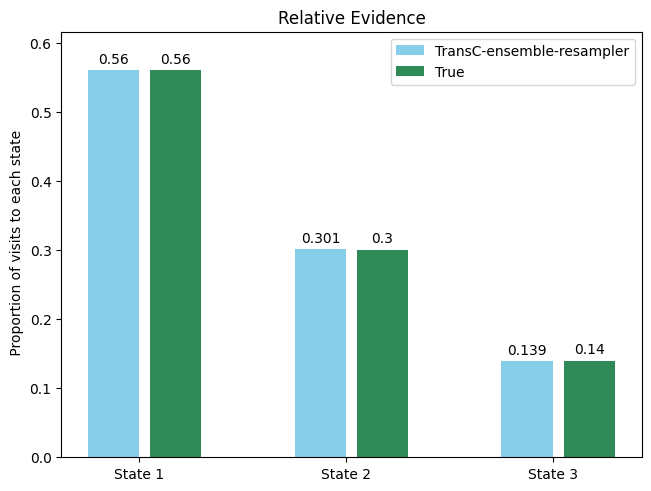

In [17]:
if(plotting):
    # extract trans-D sample
    transc_ensemble,model_chains,states_chain = tcs3.get_transc_samples(100000,returnchains=True,verbose=True)# Count visits to each state by Trans-D mcmc
    
    h=np.zeros(tcs3.nstates)
    h[list(Counter(states_chain.reshape(-1)).keys())] = list(Counter(states_chain.reshape(-1)).values())
    h/=np.sum(h)

    # plot histogram of frequency of visits to each state

    labels = ("State 1", "State 2", "State 3")
    labels = ['State '+str(i+1) for i in np.arange(nstates)]

    x = np.arange(nstates)  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')
    offset = width * multiplier
    rects = ax.bar(x + offset, np.round(h,3), width, label=tcs3.alg,color='skyblue')
    ax.bar_label(rects, padding=3)
    multiplier += 1
    offset = width * multiplier+0.05
    rects = ax.bar(x + offset, np.round(trueML,3), width, label='True',color='seagreen')
    ax.bar_label(rects, padding=3)
    multiplier += 1


    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(' Proportion of visits to each state')
    ax.set_title('Relative Evidence')
    ax.set_xticks(x + width/2, labels)
    ax.legend(loc='upper right')
    ax.set_ylim(0.,np.max(np.maximum(h,trueML))*1.1)
    #plt.savefig('Marginal_Likelihoods.png')
    plt.show()

 State;  0  in  3  dimensions
 State;  1  in  5  dimensions
 State;  2  in  10  dimensions


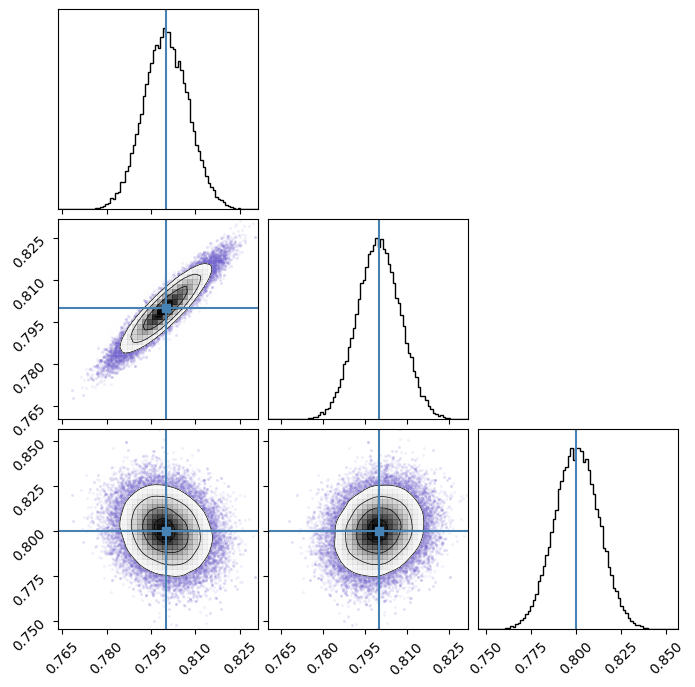

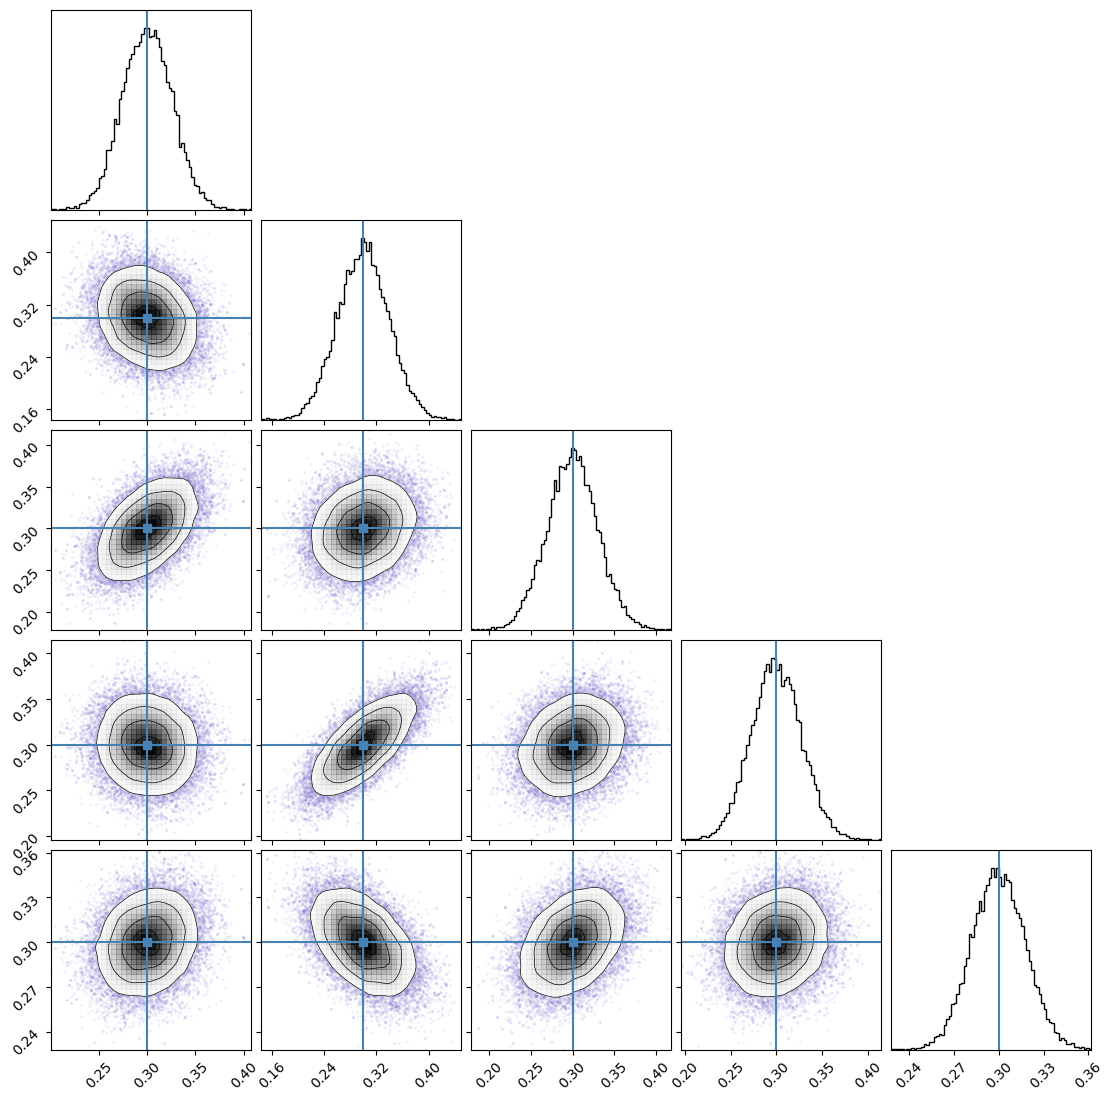

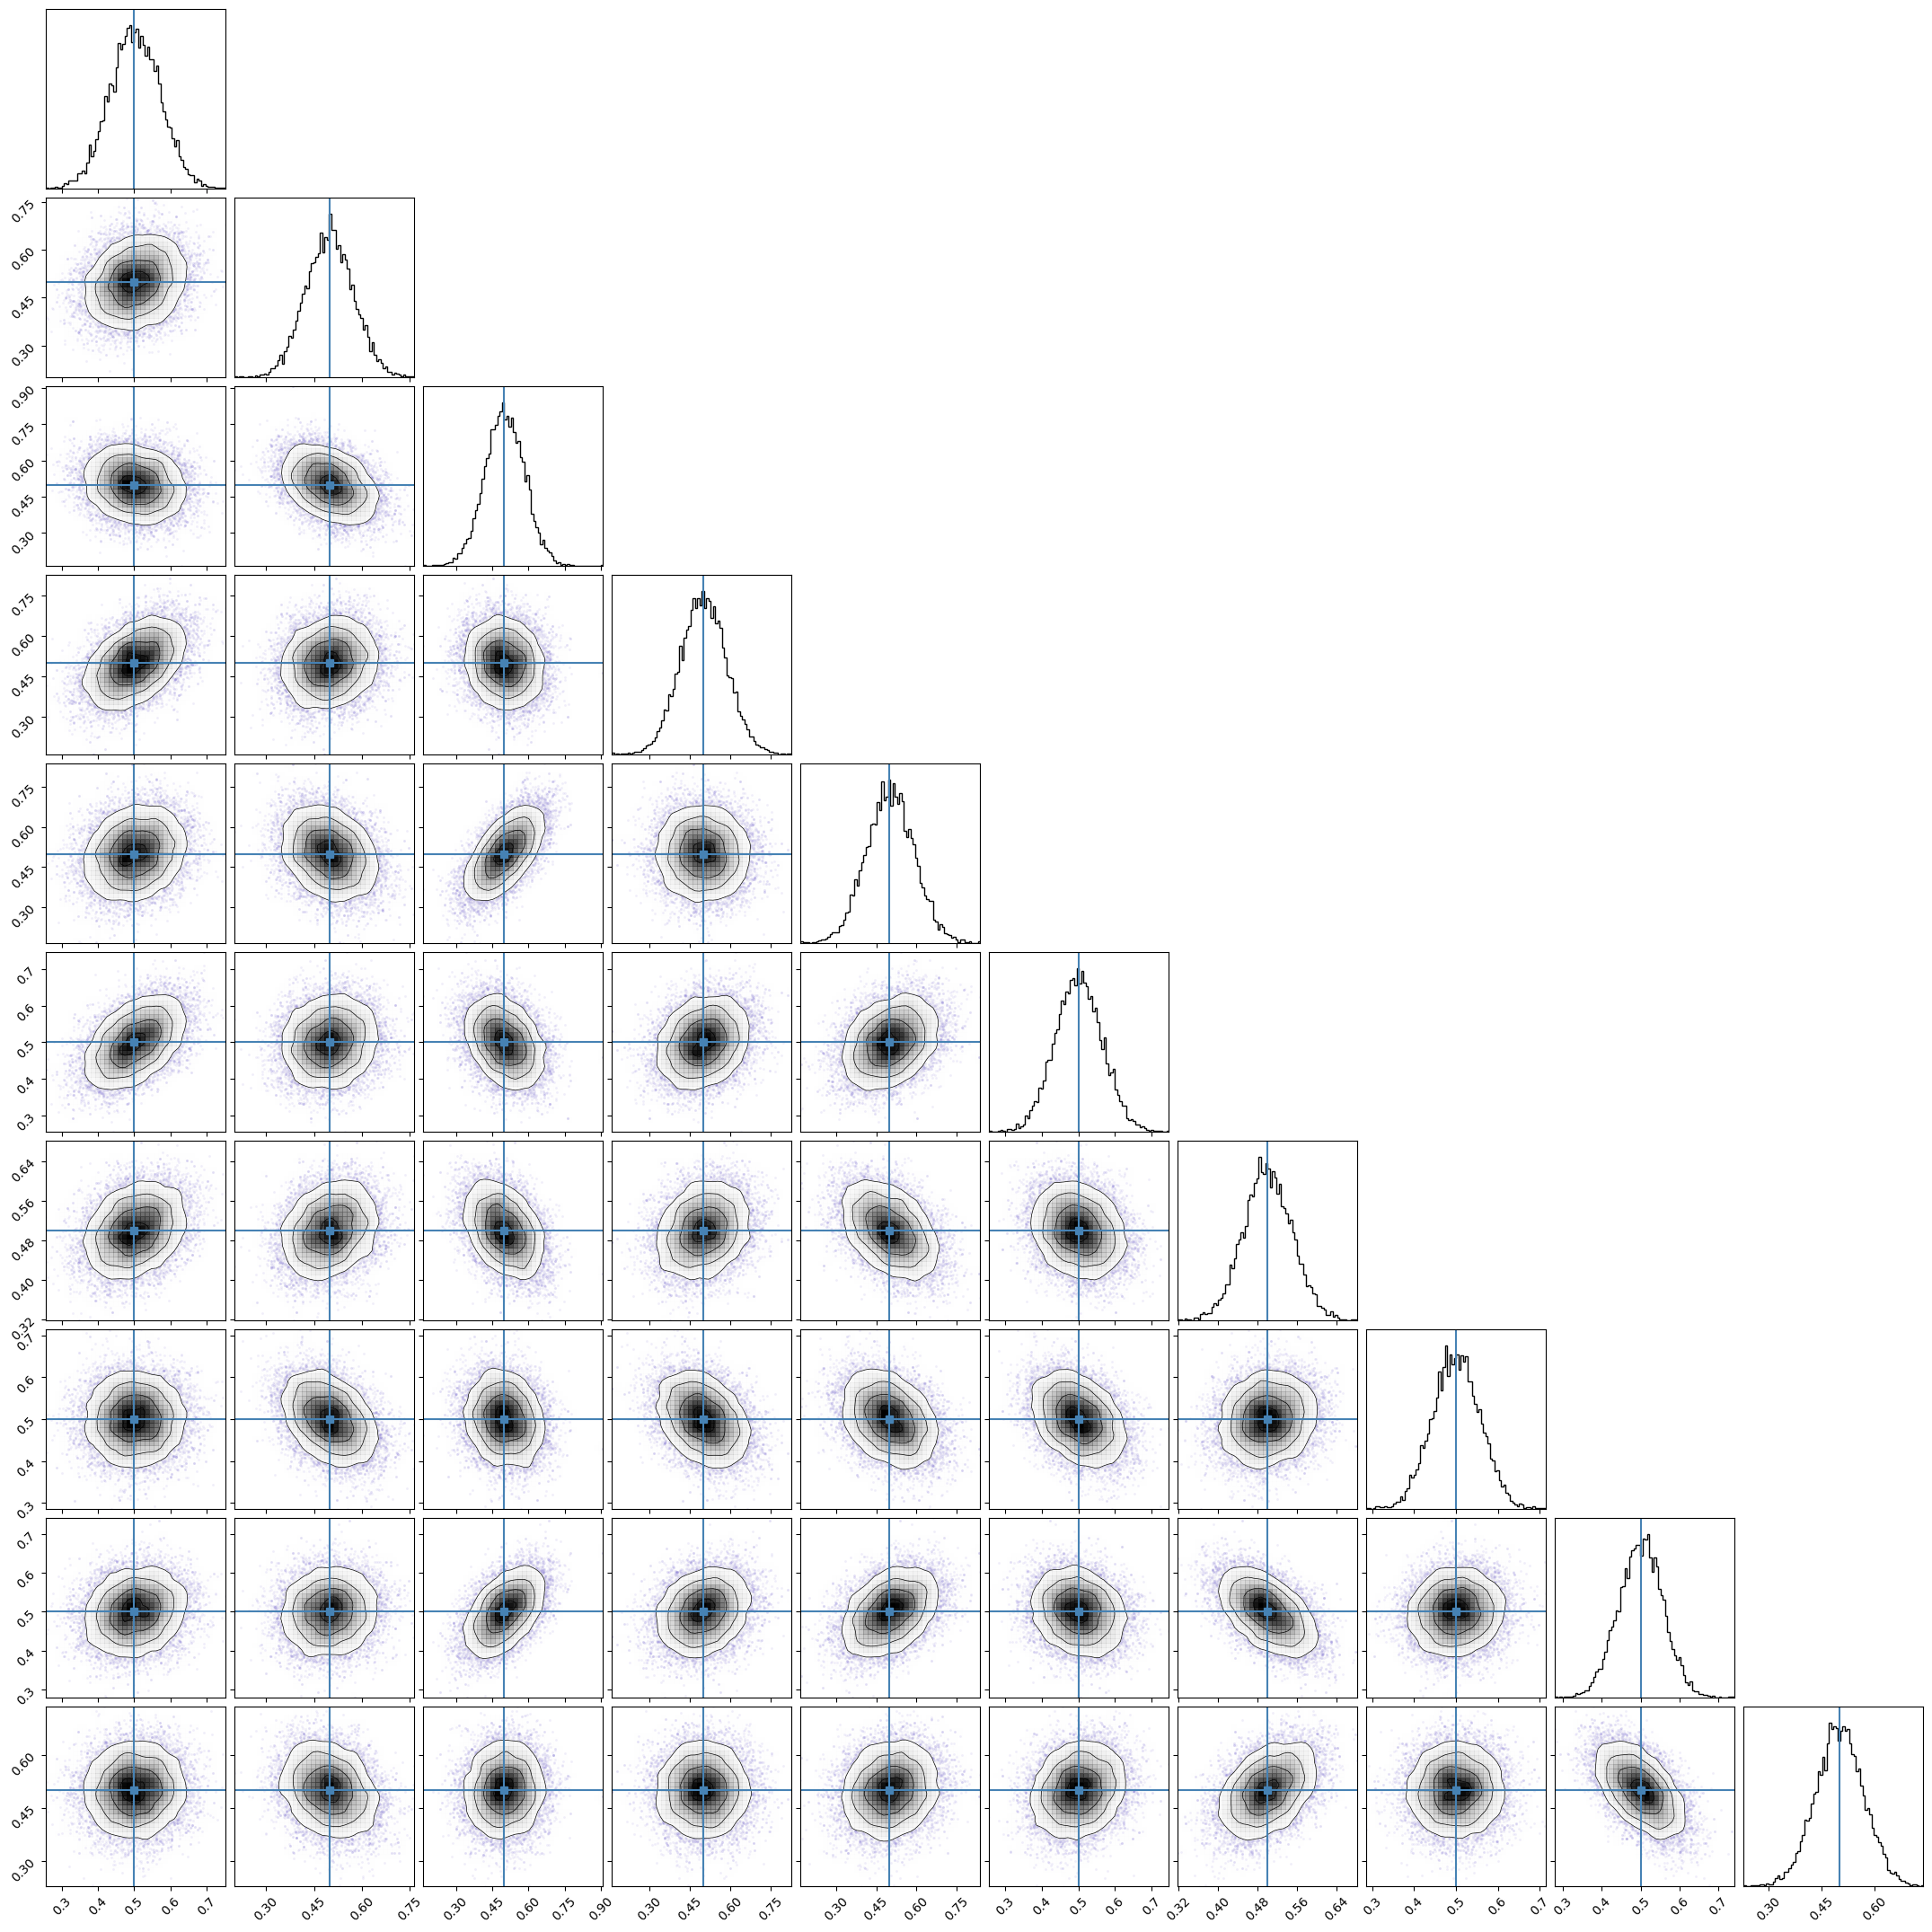

In [18]:
# corner plots to check sampling within each state
if(plotting):
    for i in range(nstates):
        string = 'State '+str(i)
        print(' State; ',i,' in ',ndims[i],' dimensions')
        fig = corner.corner(
            transc_ensemble[i], 
            truths=mu[i],
            title=string,
            bins=40,hist_bin_factor=2,smooth=True,contour_kwargs=contour_kwargs,data_kwargs=data_kwargs
            );

Density of within state samples looks reasonable.

In [19]:
print(' Here is the Trans-C ensemble with\n {} samples in state 1\n {} samples in state 2\n {} samples in state 3\n'
      .format(len(transc_ensemble[0]),len(transc_ensemble[1]),len(transc_ensemble[2])),'\n',transc_ensemble)

 Here is the Trans-C ensemble with
 55971 samples in state 1
 30137 samples in state 2
 13892 samples in state 3
 
 [array([[0.81228606, 0.81358134, 0.80465103],
       [0.80525343, 0.80839889, 0.81307535],
       [0.80704589, 0.81078348, 0.80679069],
       ...,
       [0.79207585, 0.79533931, 0.80686073],
       [0.79007499, 0.78829222, 0.79807021],
       [0.79730781, 0.79683971, 0.79653051]], shape=(55971, 3)), array([[0.32049052, 0.37039667, 0.3146458 , 0.3435497 , 0.2843495 ],
       [0.29488346, 0.32487619, 0.28039736, 0.3282648 , 0.29453381],
       [0.34285474, 0.28348789, 0.29573216, 0.26720478, 0.28133797],
       ...,
       [0.3557268 , 0.33508296, 0.33931882, 0.32093498, 0.29004012],
       [0.32529464, 0.30041529, 0.3093353 , 0.28607082, 0.29099089],
       [0.285015  , 0.31335322, 0.27603158, 0.30334895, 0.29235188]],
      shape=(30137, 5)), array([[0.48957473, 0.49546829, 0.47650176, ..., 0.50263747, 0.4864896 ,
        0.52117919],
       [0.4293426 , 0.65547866, 0.4

-------------------------------------------------------------------------------

### Example of using Laplace approximation

Here is an example of using the Laplace approximation to calculate evidence for each state using posterior ensembles.

In [20]:
tcs3.run_laplace_evidence_approximation(
    None,
    None,
    ensemble_per_state=ensemble_per_state,
    log_posterior_ens=log_posterior_ens)
tot = np.sum(np.exp(tcs3.laplace_log_marginal_likelihoods))
print(' Estimated relative evidences                        :', *np.round((np.exp(tcs3.laplace_log_marginal_likelihoods))/tot,8))

 Estimated relative evidences                        : 0.56529836 0.30513791 0.12956372
